In [1]:
from sclibrary.network_reader import NetworkReader
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from sclibrary.plot import SCPlot
import numpy as np
import matplotlib.pyplot as plt

from sclibrary.eigendecomposition import _get_eigendecomposition

### Reading data

In [3]:
data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, 
                           src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)

simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")


# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)
# create a plot
scplot = SCPlot(sc, coordinates)

### Filters

In [4]:
# frequencies
f = np.array(
    [0.28512429699931818305458364193328,
-0.88237789765813756659440514340531,
-1.3731352457670322753102709611994,
1.2467113677156391737810281483689,
-0.90497091048199007623509260156425,
0.72020108284209904958572678879136,
0.56279218322242341443484292540234,
-1.1828189377710074392524575159769,
1.3917637072266628717187586516957,
0.84253183742878834383560615606257]
    )

f_h, f_c, f_g = sc.get_hodgedecomposition(flow=f, round_fig=False)

In [8]:
L1 = sc.hodge_laplacian_matrix(rank=1)
u_1, eigenvals_u1 = _get_eigendecomposition(L1)

In [9]:
# filter frequency response H1
B1 = sc.incidence_matrix(rank=1)
B2 = sc.incidence_matrix(rank=2)

# least square based gradient extraction
H_g = B1.T @ np.linalg.pinv(B1@B1.T) @ B1
h_g = u_1.T @ H_g @ u_1
f_g_r = H_g @ f
# error
error_g = np.linalg.norm(f_g_r - f_g) / np.linalg.norm(f_g)
print("error_g: ", error_g)

error_g:  9.775907409884865e-08


In [10]:
# least square based curl extraction
H_c = B2 @ np.linalg.pinv(B2.T@B2) @ B2.T
h_c = u_1.T @ H_c @ u_1

# filtered output
f_c_r = H_c @ f

# error
error_c = np.linalg.norm(f_c_r - f_c) / np.linalg.norm(f_c)
print("error_c: ", error_c)

error_c:  7.884953353952633e-08


In [11]:
# least square based harmonic extraction
f_h_r = f - f_g_r - f_c_r
# error
error_h = np.linalg.norm(f_h_r - f_h) / np.linalg.norm(f_h)
print("error_h: ", error_h)

error_h:  2.7852469566698955e-07


In [134]:
# Direct Least Square based filter design
# Subcomponent extraction performance by filters H1
# L1 = L2 = L and α = β

def least_squares_filter_design(
    hodge_laplacian_mat,
    f_true,
    alpha, 
    filter_range = range(12)
):
    # eigenvalues and eigenvectors
    u_1, eigenvals = _get_eigendecomposition(hodge_laplacian_mat)

    # create a matrix to store the system
    system_mat = np.zeros((len(eigenvals), len(filter_range)))
    errors = []
    frequency_responses = np.zeros((len(u_1), len(filter_range)))

    for L in filter_range:
        
        system_mat[:, L] = np.power(eigenvals, L)

        # Least square solution to obtain the filter coefficients
        h = np.linalg.pinv(system_mat)
        # keep only the desired subcomponent
        h = np.dot(h, alpha)
        
        # building the topological filter
        H_1 = np.zeros_like(hodge_laplacian_mat)
        
        for l in range(len(h)):
            H_1 += h[l] * np.linalg.matrix_power(L1, l)
        
        # filter the signal
        f_estimated = H_1 @ f
        
        # compute the error
        error = np.linalg.norm(f_estimated - f_true) / np.linalg.norm(f_true)
        errors.append(error)
        
        # filter frequency response 
        H_1_tilda = np.diag(u_1.T @ H_1 @ u_1)
        frequency_responses[:, L] = H_1_tilda
        
    return errors, frequency_responses

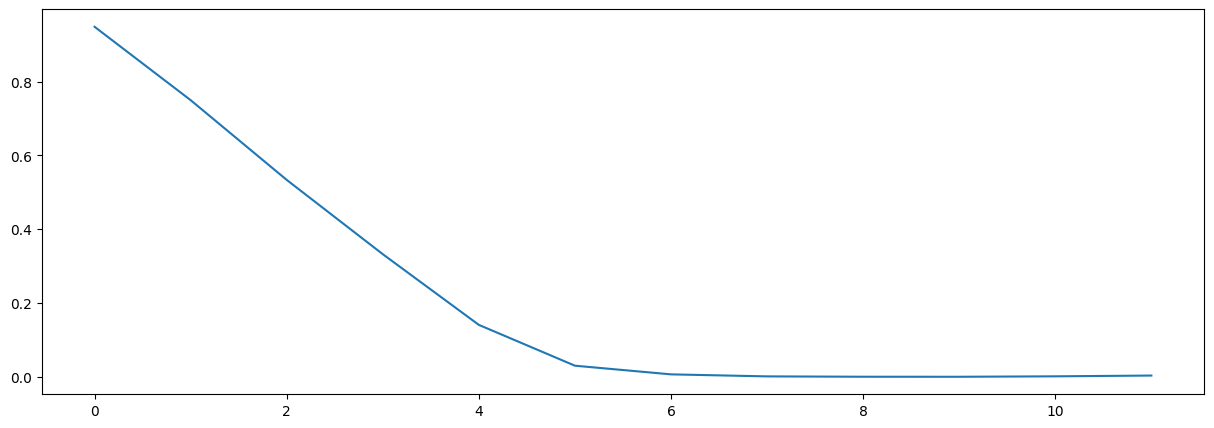

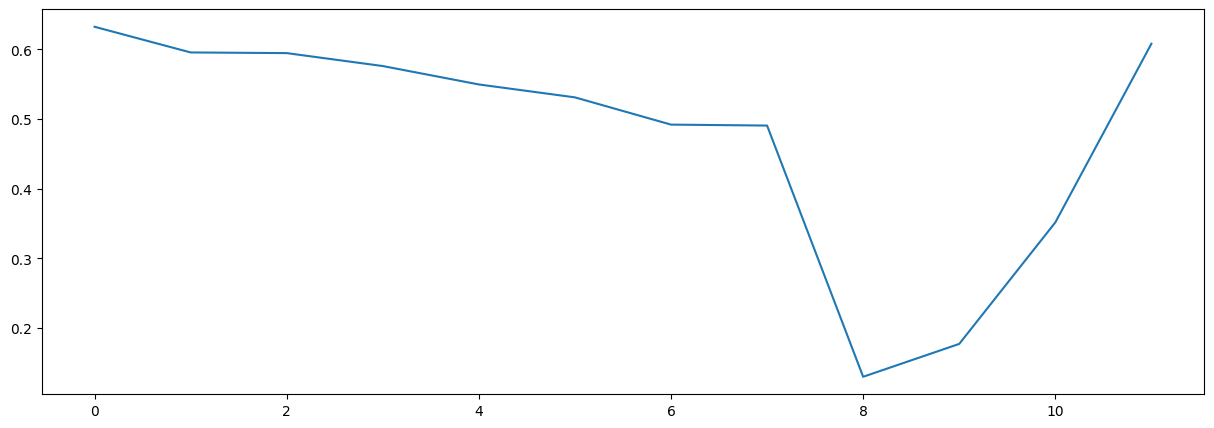

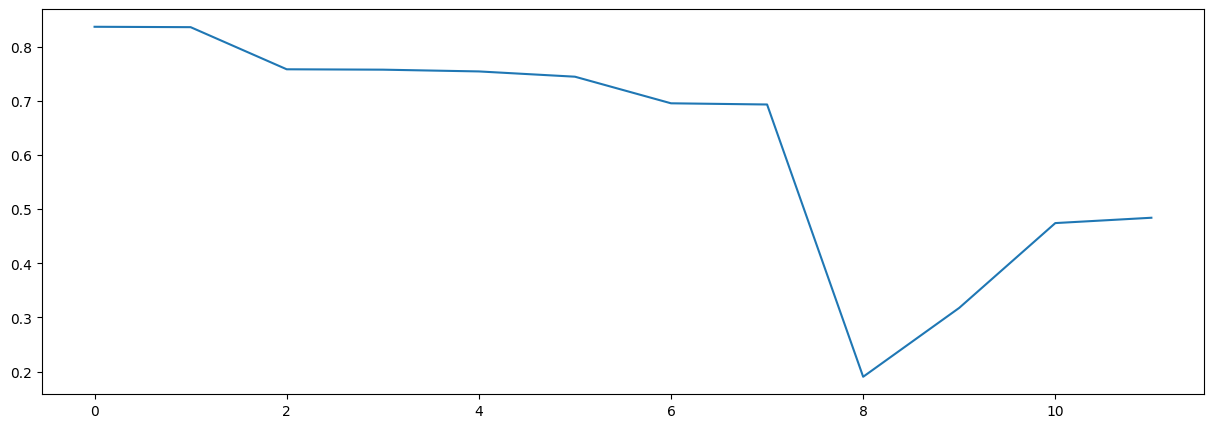

In [135]:
filter_range = range(12)

# harmonic 
alpha = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
f_true = f_h
errors, frequency_responses = least_squares_filter_design(
    L1, f_true, alpha, filter_range

)
plt.figure(figsize=(15, 5))
plt.plot(filter_range, errors)


# gradient
alpha = np.array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1])
f_true = f_g
errors, frequency_responses = least_squares_filter_design(
    L1, f_true, alpha, filter_range
)
plt.figure(figsize=(15, 5))
plt.plot(filter_range, errors)

# curl
alpha = np.array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0])
f_expected = f_c
errors, frequency_responses = least_squares_filter_design(
    L1, f_expected, alpha, filter_range
)
plt.figure(figsize=(15, 5))
plt.plot(filter_range, errors)

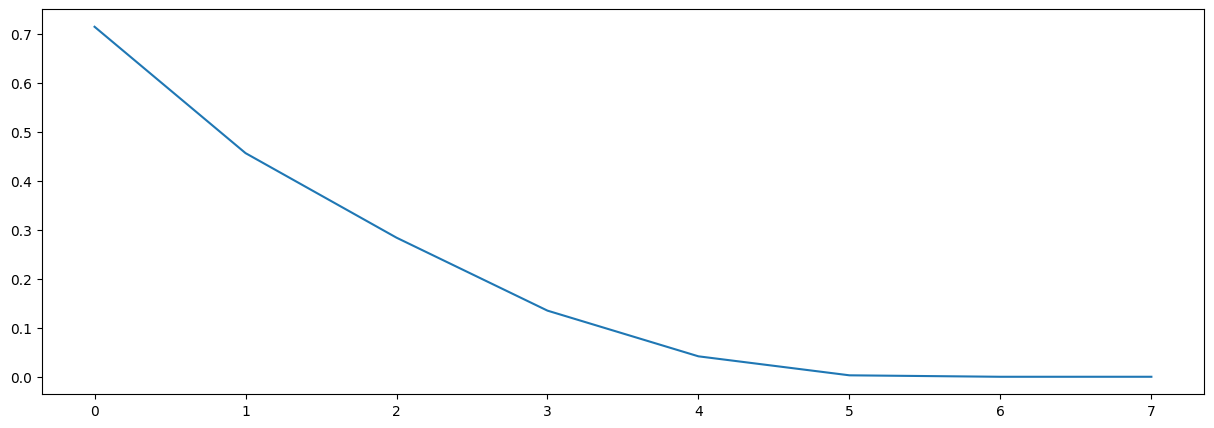

In [144]:
# Subcomponent extraction by filters H1 based on the LS design

# curl - zero coffients on the α
# gradient - zero coffients on the β

from sclibrary.eigendecomposition import _get_eigendecomposition

# 
tolerance = 1e-06
L1L = sc.lower_laplacian_matrix(rank=1)
u_1L, eigenvals_u1L = _get_eigendecomposition(L1L, tolerance)
eigenvals_u1L = np.unique(eigenvals_u1L)

# desired subcomponent
a = [0] + [1] * (len(eigenvals_u1L) - 1) # gradient

filter_range = range(8)
system_mat = np.zeros((len(eigenvals_u1L), len(filter_range)))
frequency_responses = np.zeros((len(u_1L), len(filter_range)))
errors = []


for L in filter_range:
    system_mat[:, L] = np.power(eigenvals_u1L, L)
    
    h = np.linalg.pinv(system_mat)
    h = np.dot(h, a)
    
    H = np.zeros_like(L1)
    
    for l in range(len(h)):
        H = H + (h[l] * np.linalg.matrix_power(L1L, l))
    
    f_estimated = H @ f
    error = np.linalg.norm(f_estimated - f_g) / np.linalg.norm(f_g)
    errors.append(error)
    
    H_1_tilda = np.diag(u_1L.T @ H @ u_1L)
    frequency_responses[:, L] = H_1_tilda

plt.figure(figsize=(15, 5))
plt.plot(filter_range, errors)